In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
zip_file = '/content/homer_bart_1.zip'

z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
print(os.listdir('/content/homer_bart_1'))

['homer24.bmp', 'bart93.bmp', 'homer17.bmp', 'homer40.bmp', 'bart109.bmp', 'homer50.bmp', 'homer101.bmp', 'bart48.bmp', 'homer16.bmp', 'bart101.bmp', 'bart110.bmp', 'homer99.bmp', 'bart67.bmp', 'bart46.bmp', 'bart76.bmp', 'homer97.bmp', 'homer49.bmp', 'bart70.bmp', 'bart34.bmp', 'homer10.bmp', 'bart59.bmp', 'bart138.bmp', 'bart44.bmp', 'bart99.bmp', 'homer95.bmp', 'homer44.bmp', 'homer113.bmp', 'homer106.bmp', 'bart27.bmp', 'homer76.bmp', 'bart146.bmp', 'bart26.bmp', 'bart162.bmp', 'bart13.bmp', 'homer13.bmp', 'homer29.bmp', 'homer107.bmp', 'bart16.bmp', 'homer86.bmp', 'bart55.bmp', 'bart56.bmp', 'bart104.bmp', 'homer54.bmp', 'homer87.bmp', 'homer100.bmp', 'homer72.bmp', 'bart31.bmp', 'bart89.bmp', 'homer3.bmp', 'homer15.bmp', 'homer117.bmp', 'homer9.bmp', 'bart74.bmp', 'bart143.bmp', 'bart53.bmp', 'bart14.bmp', 'homer104.bmp', 'bart106.bmp', 'homer33.bmp', 'bart64.bmp', 'bart158.bmp', 'bart30.bmp', 'bart105.bmp', 'bart97.bmp', 'homer43.bmp', 'homer60.bmp', 'bart5.bmp', 'homer79.bmp', 

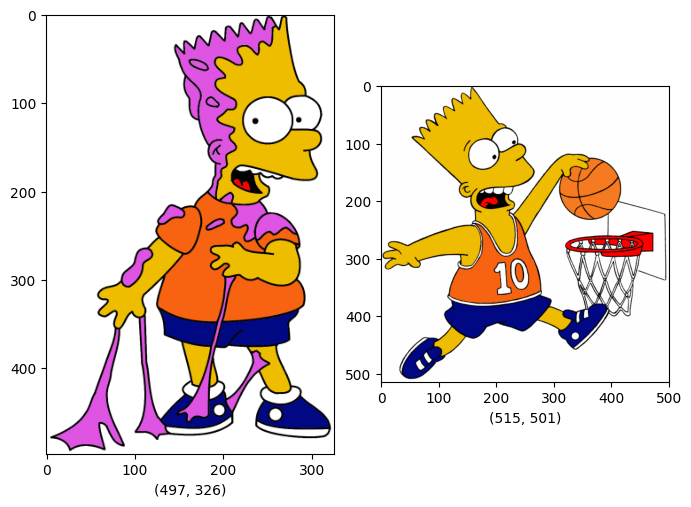

In [ ]:
plt.figure(figsize=(7,7))
for i in range(2):
  plt.subplot(1,2,i+1)
  img = plt.imread(f"/content/homer_bart_1/bart{i+1}.bmp")
  plt.tight_layout()
  plt.imshow(img)
  plt.xlabel(img.shape[:2])

Размеры изображений в сете неодинаковые, поэтомы изменим их.

In [ ]:
import cv2

In [ ]:
height = 128
width = 128

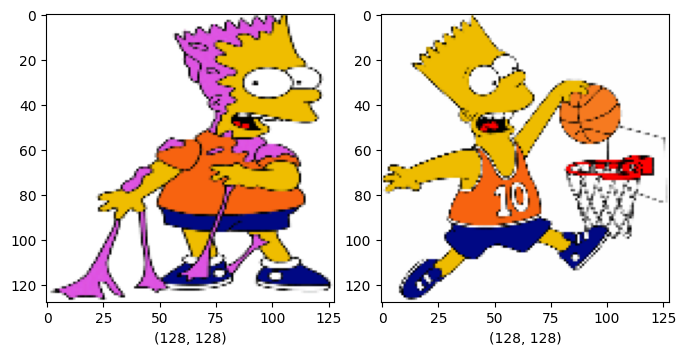

In [ ]:
plt.figure(figsize=(7,7))
for i in range(2):
  plt.subplot(1,2,i+1)
  img = plt.imread(f"/content/homer_bart_1/bart{i+1}.bmp")
  img_resized = cv2.resize(img, (height, width))
  plt.tight_layout()
  plt.imshow(img_resized)
  plt.xlabel(img_resized.shape[:2])

In [ ]:
images = []
labels = []
class_labels = ['Homer', 'Bart']

for filename in (os.listdir('/content/homer_bart_1')):
  img = plt.imread(f"/content/homer_bart_1/{filename}")
  img_resized = cv2.resize(img, (height, width))
  images.append(img_resized)

  if filename.startswith('homer'):
    labels.append(0)
  elif filename.startswith('bart'):
    labels.append(1)

images = np.array(images).astype('float32') / 255.0
labels = np.array(labels)

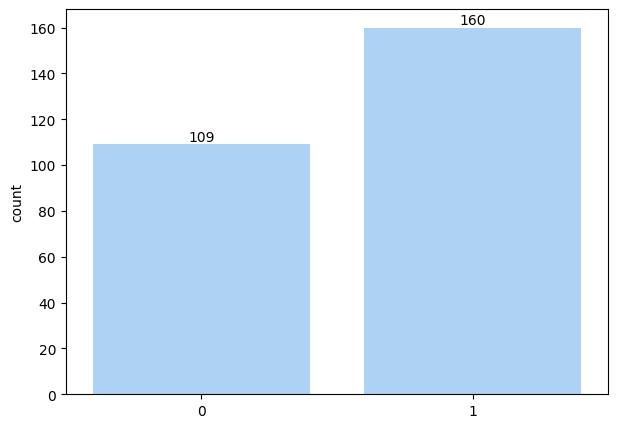

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x=labels, color='#a2d2ff')
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 128, 128, 3) (41, 128, 128, 3) (228,) (41,)


In [ ]:
print(f'Homer train labels: {sum(y_train == 0)}\nBart train labels: {sum(y_train == 1)}')
print(f'\nHomer test labels: {sum(y_test == 0)}\nBart test labels: {sum(y_test == 1)}')

Homer train labels: 88
Bart train labels: 140

Homer test labels: 21
Bart test labels: 20


Так как классы для тренировочной выборки не сбалансированы, сбалансируем данные с помощью RandomUnderSampler - уменьшим выборку большинства классов случайным отбором.

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

rus = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train_reshaped, y_train)

print(f'Homer train labels: {sum(y_train_rus == 0)}\nBart train labels: {sum(y_train_rus == 1)}')
print(f'X_train shape: {X_train_rus.shape}; y_train shape: {y_train_rus.shape}')

Homer train labels: 88
Bart train labels: 88
X_train shape: (176, 49152); y_train shape: (176,)


In [ ]:
y_train = y_train_rus

return_shape = list(X_train.shape)
return_shape[0] = X_train_rus.shape[0]
X_train = X_train_rus.reshape(return_shape)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(176, 128, 128, 3) (41, 128, 128, 3) (176,) (41,)


# TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

## Hyperopt

In [ ]:
import hyperopt
from hyperopt import fmin, tpe, hp
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

In [ ]:
def get_model(params):
  model = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(params['hidden_layer1'], activation='relu'),
      Dense(params['hidden_layer2'], activation='relu'),
      Dense(2, activation='softmax')
    ])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=params['learning_rate']),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=0)
  val_accuracy = history.history['val_accuracy'][-1]

  return -val_accuracy  # минимизация, тк Hyperopt ищет минимум функции

In [ ]:
params = {
    'hidden_layer1': hp.choice('hidden_layer1', [32, 64, 128, 256, 512, 1024]),
    'hidden_layer2': hp.choice('hidden_layer2', [32, 64, 128, 256, 512, 1024]),
    'learning_rate': hp.loguniform('learning_rate', -5, -1)
}

In [ ]:
best = fmin(fn=get_model,
            space=params,
            algo=tpe.suggest,
            max_evals=10)  # кол-во экспериментов

100%|██████████| 10/10 [12:05<00:00, 72.59s/trial, best loss: -0.6585366129875183]


In [ ]:
best

{'hidden_layer1': 3, 'hidden_layer2': 3, 'learning_rate': 0.012441779267071325}

In [ ]:
model = Sequential([
    Flatten(input_shape=X_train.shape[1:]),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.012441779267071325),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5185 - loss: 0.6931
Accuracy of test images: 51.22%


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Confusion Matrix:
[[21  0]
 [20  0]]


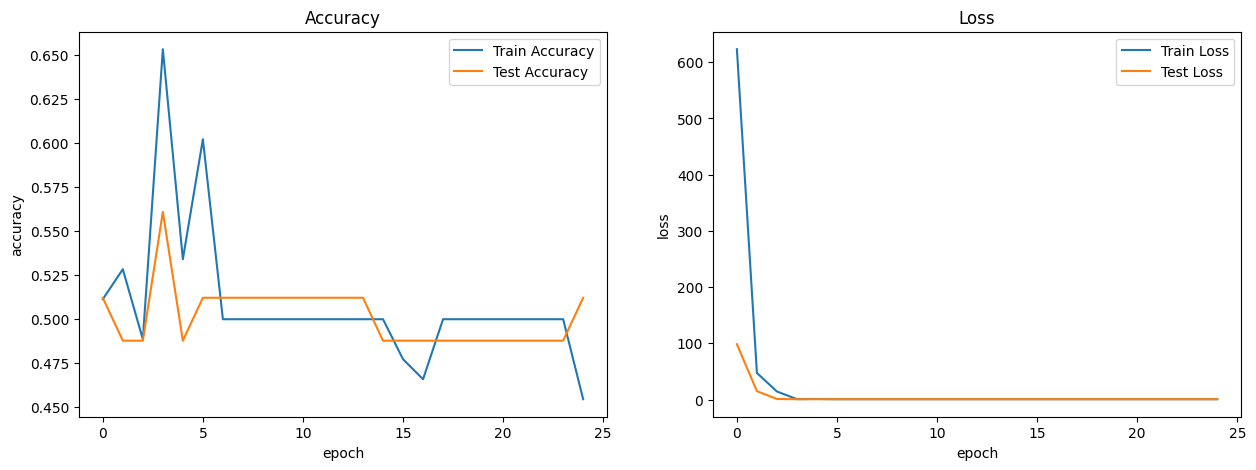

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## GridSearch

In [ ]:
!pip uninstall scikit-learn

In [ ]:
!pip install scikeras

In [ ]:
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

In [ ]:
def create_model(hidden_layer, learning_rate):
  model = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(hidden_layer, activation='relu'),
      Dense(2, activation='softmax')
    ])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
model = KerasClassifier(create_model, hidden_layer=64, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4271 - loss: 333.9337


KerasClassifier(
	model=<function create_model at 0x7b40efbd0160>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	hidden_layer=64
	learning_rate=0.01
	class_weight=None
)

In [ ]:
param_grid = {
    'hidden_layer': [32, 64, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)

In [ ]:
print(grid_result.best_score_, grid_result.best_params_)

0.6073446327683616 {'hidden_layer': 256, 'learning_rate': 0.01}


In [ ]:
model_grid = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(256, activation='relu'),
      Dense(2, activation='softmax')
    ])

model_grid.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history = model_grid.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model_grid.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7586 - loss: 7.3418
Accuracy of test images: 73.17%


In [ ]:
y_pred = model_grid.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Confusion Matrix:
[[13  8]
 [ 3 17]]


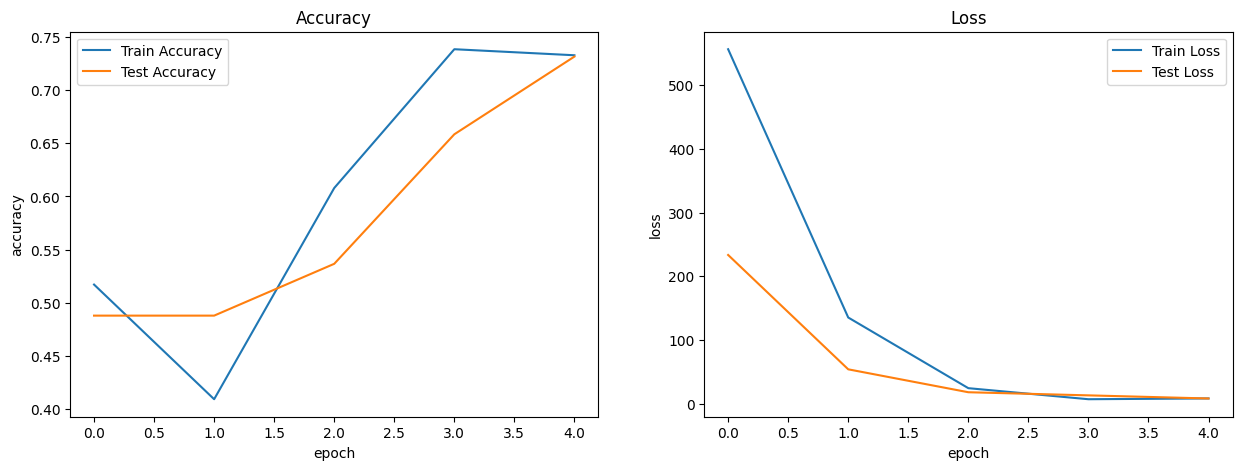

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
params_random = {
    'hidden_layer': [32, 64, 256, 512, 1024],
    'learning_rate': [0.001, 0.01, 0.1]
}

rs = RandomizedSearchCV(estimator=model, param_distributions=params_random, refit=False, cv=3, scoring='accuracy')
rs_result = rs.fit(X_train, y_train)

In [ ]:
print(rs_result.best_score_, rs_result.best_params_)

0.5734463276836158 {'learning_rate': 0.01, 'hidden_layer': 1024}


In [ ]:
model_rs = Sequential([
      Flatten(input_shape=X_train.shape[1:]),
      Dense(1024, activation='relu'),
      Dense(2, activation='softmax')
    ])

model_rs.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history = model_rs.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model_rs.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6415 - loss: 0.9474
Accuracy of test images: 63.41%


In [ ]:
y_pred = model_rs.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Confusion Matrix:
[[18  3]
 [12  8]]


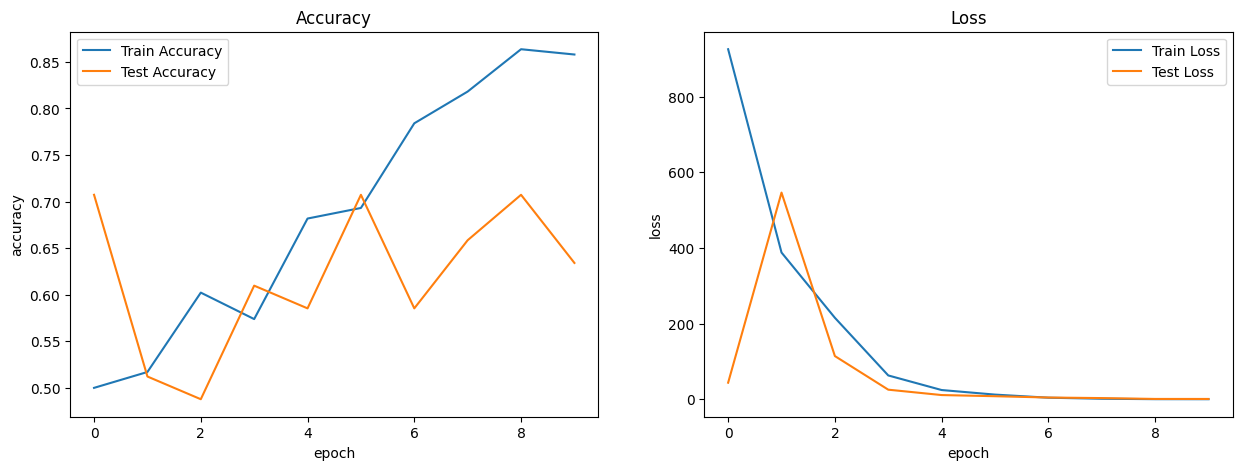

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [ ]:
def objective(trial):
    neurons = trial.suggest_categorical('neurons', [32, 64, 128, 256, 512, 1024])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(neurons, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [ ]:
study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=10)

[I 2024-05-27 15:56:46,135] A new study created in memory with name: no-name-f3f280ea-b85f-4821-b6b1-5524e15aefe7
[I 2024-05-27 15:58:16,948] Trial 0 finished with value: 0.707317054271698 and parameters: {'neurons': 1024, 'learning_rate': 0.0044098172756840345}. Best is trial 0 with value: 0.707317054271698.
[I 2024-05-27 15:58:25,530] Trial 1 finished with value: 0.707317054271698 and parameters: {'neurons': 128, 'learning_rate': 1.2169732903248104e-05}. Best is trial 0 with value: 0.707317054271698.
[I 2024-05-27 15:59:24,223] Trial 2 finished with value: 0.6097561120986938 and parameters: {'neurons': 512, 'learning_rate': 0.007136127480356943}. Best is trial 0 with value: 0.707317054271698.
[I 2024-05-27 16:01:18,051] Trial 3 finished with value: 0.6097561120986938 and parameters: {'neurons': 1024, 'learning_rate': 0.0002789528653745182}. Best is trial 0 with value: 0.707317054271698.
[I 2024-05-27 16:01:42,607] Trial 4 finished with value: 0.6341463327407837 and parameters: {'neur

In [ ]:
print('Best parameters:', study.best_params)
print('Accuracy: {:.2f}%'.format(study.best_value * 100))

Best parameters: {'neurons': 512, 'learning_rate': 0.0017864212670756071}
Accuracy: 75.61%


In [ ]:
model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(512, activation='relu'),
        Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0017864212670756071),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6949 - loss: 4.1069
Accuracy of test images: 68.29%


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Confusion Matrix:
[[15  6]
 [ 7 13]]


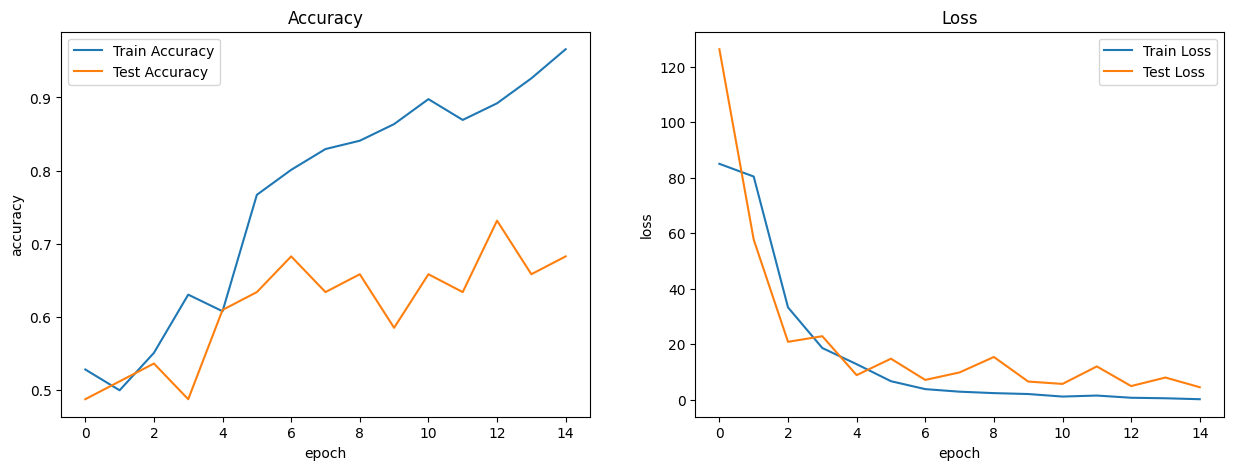

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## BayesianOptimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def bayes_opt(neurons1, neurons2, learning_rate):
    model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(int(neurons1), activation='relu'),
        Dense(int(neurons2), activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, validation_split=0.1, verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy

In [ ]:
params_bayes_opt = {
    'neurons1': (24, 1024),
    'neurons2': (24, 1024),
    'learning_rate': (1e-4, 1e-2)
    }

optimizer = BayesianOptimization(f=bayes_opt, pbounds=params_bayes_opt, verbose=2, random_state=10)
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... | neurons1  | neurons2  |
-------------------------------------------------------------
| 1         | 0.0       | 0.007736  | 44.75     | 657.6     |
| 2         | 1.0       | 0.007513  | 522.5     | 248.8     |
| 3         | 1.0       | 0.002061  | 784.5     | 193.1     |
| 4         | 0.0       | 0.0009746 | 709.4     | 977.4     |
| 5         | 0.6111    | 0.0001391 | 536.2     | 836.6     |
| 6         | 0.0       | 0.007858  | 786.3     | 189.8     |
| 7         | 0.0       | 0.009542  | 741.3     | 541.2     |
| 8         | 1.0       | 0.001317  | 673.3     | 831.6     |
| 9         | 0.0       | 0.0009931 | 748.6     | 752.5     |
| 10        | 0.6111    | 0.004394  | 501.7     | 443.0     |
| 11        | 0.0       | 0.005002  | 53.94     | 667.8     |
| 12        | 0.0       | 0.004125  | 42.2      | 288.7     |
| 13        | 0.0       | 0.003628  | 450.4     | 298.7     |
| 14        | 0.6667    | 0.009828  | 996.9     | 469.6     |
| 15    

In [ ]:
print('Best parameters:', optimizer.max['params'])
print('Best validation accuracy:', optimizer.max['target'])

Best parameters: {'learning_rate': 0.007513158437132258, 'neurons1': 522.5070123025904, 'neurons2': 248.79664553084766}
Best validation accuracy: 1.0


In [ ]:
model = Sequential([
        Flatten(input_shape=X_train.shape[1:]),
        Dense(int(522.5070123025904), activation='relu'),
        Dense(int(248.79664553084766), activation='relu'),
        Dense(2, activation='softmax')
    ])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.007513158437132258),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), verbose=1)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Accuracy of test images: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6415 - loss: 1.7237
Accuracy of test images: 63.41%


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Confusion Matrix:
[[17  4]
 [11  9]]


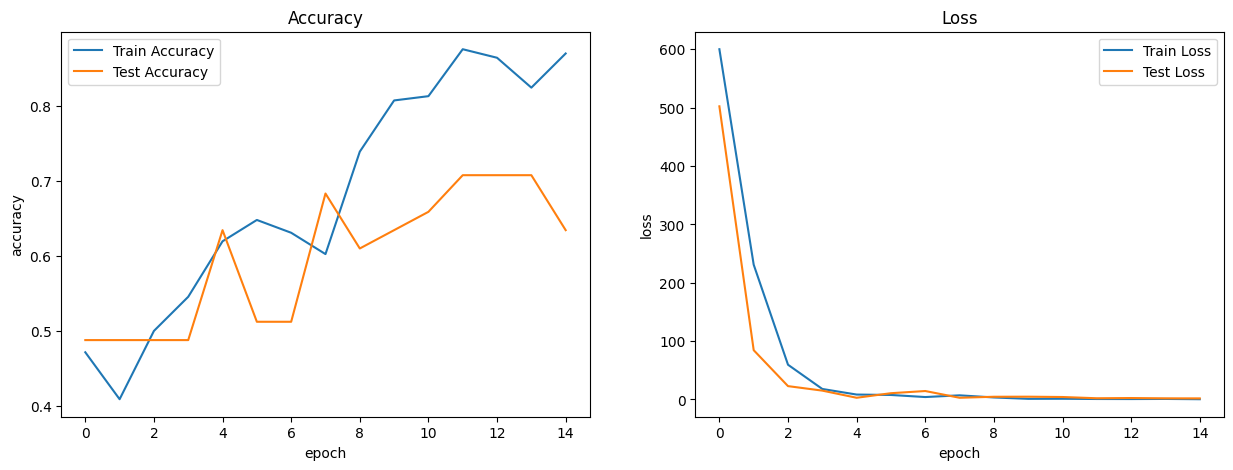

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

P.S. Не все модели одинаковые.

Лучший реультат получился у модели с использованием GridSearch (73.17%), затем идет Optuna (68.29%). Hyperopt в данном сете справился хуже всех (51.22%).